# Learn `QFit` in 10? minutes

Tianpu Zhao, Danyang Chen and Jens Koch

This guide will walk you through the basic usage of `QFit` and its features. We have prepared a simple task for you to practice fitting with `QFit`. Don't worry, we've also prepared a detailed guide for you to follow. 

## The task
You are given a **superconducting circuit** composed of a fluxonium qubit and a resonator. They are coupled by a capacitor. The circuit is shown below:
<p align="center">
  <img width="300" src="resources/images/example_circuit.png">
</p>  

This circuit is described by the following **Hamiltonian**:
$$
H = H_{\rm res} + H_{\rm qubit} + H_{\rm int}
$$
where
\begin{align*}
H_{\rm res} &= E_{\rm osc} a^\dagger a \\
H_{\rm qubit} &= -4E_C n^2 + E_J \cos(\varphi+2\pi\Phi_{\rm ext}/\Phi_0) + \frac{1}{2}E_L\varphi^2 \\
H_{\rm int} &= -i\frac{g}{\sqrt{2}l_{\rm osc}} (a-a^\dagger) n
\end{align*}
where $a$ is the annihilation operator of the resonator, $n$ ($\varphi$) is the number (phase) operator of the qubit. $\Phi_{\rm ext}$ is the external flux, and $\Phi_0$ is the flux quantum.  Other circuit parameters and their estimates are listed below:

| Parameter | Symbol | Rough Estimate |
| --- | --- | --- |
| Josephson Energy | $E_J$ | 3.0 GHz |
| Charging Energy | $E_C$ | 0.9 GHz |
| Inductive Energy | $E_L$ | 0.25 GHz |
| Oscillator Length | $l_{\rm osc}$ | 1.0 |
| Resonator Frequency | $E_{\mathrm{osc}}$ | 6.0 GHz |
| Coupling Strength | $g$ | 0.1 GHz |

To determine the parameter described above, we perform **two-tone spectroscopy experiment**. We apply a tone with frequency $f_{\rm d}$ to the qubit and a tone with frequency $E_{\rm osc} / h$ to the resonator. We measure the transmission or reflection of the rf signal through the resonator. We perform such measurement for different $f_{\rm d}$ and $\Phi_{\rm ext}$, and obtain the following data:

Below is the information of the data and the shape of elements:
flux (81,)
freq (2793,)
mags (81, 2793)


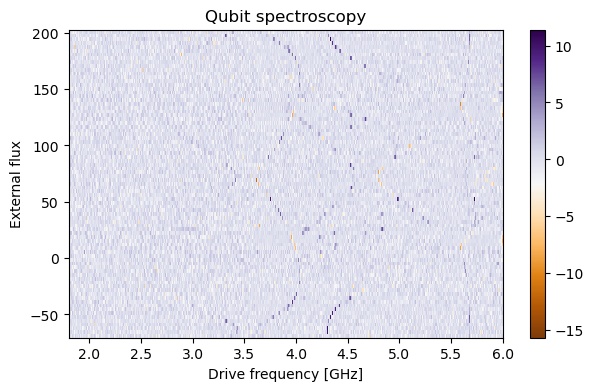

In [2]:
# The code below is just for showing the format of the data.
# Not an actual part of this tutorial.

import h5py
import numpy as np
import matplotlib.pyplot as plt

# Load the data
print("Below is the information of the data and the shape of elements:")
with h5py.File("./example_data/joint_qubit_twotone.h5", "r") as file:
    def print_info(name, obj):
        print(name, obj.shape)
    file.visititems(print_info)

    data = np.array(file["mags"])
    f_d, Phi_ext = np.meshgrid(file["freq"], file["flux"])

# Plot the data
plt.figure(figsize=(7, 4))
plt.pcolormesh(f_d, Phi_ext, data, cmap="PuOr", rasterized=True)
plt.colorbar()
plt.xlabel("Drive frequency [GHz]")
plt.ylabel("External flux")
plt.title("Qubit spectroscopy")
plt.show()

The peak of the measurement date represents a resonance between two energy eigenstates of the system. We can use a numerical model to **fit the data** and extract the parameters - This is where `QFit` comes in. 

**Your task is to use `QFit` to fit the data and extract the parameters.**

## Step 1: Build a numerical model
We have helped you to create a numerical model of the quantum system using `scqubits.HilbertSpace`. To see the usage of `scqubits` in detail, please refer to the [scqubits documentation](https://scqubits.readthedocs.io/en/latest/).

In [3]:
import scqubits as scq

resonator = scq.Oscillator(
    E_osc = 6,
    l_osc = 1.0,
    truncated_dim = 4,
    id_str = "resonator"
)
    
fluxonium = scq.Fluxonium(
    EJ = 7.0,
    EC = 1,
    EL = 0.2,
    flux = 0.0,
    cutoff = 100,
    truncated_dim = 5,
    id_str = "fluxonium"
)

hilbertspace = scq.HilbertSpace([resonator, fluxonium])

hilbertspace.add_interaction(
    g = 1,
    op1 = resonator.n_operator,
    op2 = fluxonium.n_operator,
    add_hc = False,
    id_str = "res-qubit"
)

## Step 2: Run `QFit` and fit the data
Open a GUI using `Fit(<HilbertSpace>)`. An GUI will pop up and we'll guide you through the GUI in the next few subsections.

In [4]:
from qfit import Fit
fit = Fit(hilbertspace, "./example_data/joint_qubit_twotone.h5")

qt.qpa.fonts: Populating font family aliases took 90 ms. Replace uses of missing font family "Roboto Medium" with one that exists to avoid this cost. 


### Step 2.0: An overview of the GUI
After launching the GUI, you will see a window below. The main window is divided into 4 parts as shown below. 
<p align="center">
  <img width="600" src="resources/images/GUI_overview.png">
</p>  

The fitting task is divided into 4 steps and you can navigate through them using the "Major Steps" panel. The 4 steps are: Calibrate, Extract, Pre-Fit and Fit. Let's go through them one by one and you may perform the corresponding task as you read along.

### Step 2.1: Calibrate
The first window you'll see after launching the GUi is the calibration panels. Please perform those tasks:
1. In the **DATA** panel: Swap the axes of the data - making flux the x-axis and frequency the y-axis.
2. In the **CALIBRATION** panel: Calibrate the data by establish a map between the control voltage (unit: mV) to external flux (unit: $\Phi_0$) as shown below:
<p align="center">
    <img width="300" src="resources/images/calibration_x1x2y1y2.png">
</p>  

*Hint: For a fluxonium, the Hamiltonian is periodic in flux with period $\Phi_0$ and symmetric around $\Phi_{\rm ext} = \frac{m}{2} \Phi_0$, where $m\in\mathbb{Z}$. Therefore, we can identify and map the x coordinates with those properties.

### Step 2.2: Extract
Now let's navigate to the next step and work on the data extraction. You just simply 
1. Create a group of **TRANSITION** data (if necessary) and **LABEL** it.
2. Click on the canvas near a peak to select it
3. Repeat the steps above

To assist you in the data extraction, you may use the buttons near the plot.
<p align="center">
    <img width="300" src="resources/images/MPL_buttons.png">
</p>  

They are (from left to right): **Reset | Pan, Zoom, Extract | X-Snapping, Y-Snapping**. Specifically, the **X-Snapping** button helps to align the x-coordinate among different transitions (groups) and reduce the fitting time considerably.
<p align="center">
    <img width="200" src="resources/gifs/X_snap.gif">
</p>  

And the **Y-Snapping** button assist you to locate the peak precisely.
<p align="center">
    <img width="200" src="resources/gifs/Y_snap.gif">
</p>

### Step 2.3: Pre-Fit
After getting enough data, we now start to fit by eye, aiming to find a good initial guess for the numerical fitting. In this step, you may play with **sliders** to make the numerical spectrum match the data. 

After getting a good set of parameters, you will click **RESULT → FIT** button on the bottom left to copy the parameters to the **FIT** panel.

### Step 2.4: Fit
Finally, we are ready to fit the data numerically! The main thing you need to do is configure the fitting parameters in the **FIT table**. You may adjust
- Whether to **Fix** or free a parameter during fitting
- The **initial guess**es
- **Min** and **Max** values

Now click **RUN FIT** and wait for the fitting to finish. 

If there is not warning or error message, congratulations! You have successfully fit the data. 

## Step 3: Save, load and export
You may save / load the fitting session by clicking the <img width="20" src="resources/images/menu.png"> button on the top left. The session will be saved as a `.qfit` file.

You can also open a new window to load the previous session.

In [5]:
# this is an example file we already prepared for you
fit = Fit.open("example_data/Learn_QFit_in_10_mins.qfit") 

There is another option for you to continue working in the notebook - export.

In [6]:
# To get a dictionary of the fit parameters
param_dict = fit.exportParameters()
param_dict

{'resonator (Oscillator).E_osc': 6.1,
 'fluxonium (Fluxonium).EJ': 3.336991935928676,
 'fluxonium (Fluxonium).EC': 1.00071813781093,
 'fluxonium (Fluxonium).EL': 0.20138123194662833,
 'Interactions.g1': 0.1}

In [7]:
# To get the HilbertSpace object and continue working on it
fit_hilbertspace = fit.exportHilbertSpace(deepcopy=True)
fit_hilbertspace

HilbertSpace(**{'subsystem_list': [Oscillator(**{'E_osc': 2.0, 'l_osc': 1.0, 'truncated_dim': 4, 'id_str': 'resonator'}), Fluxonium(**{'EJ': 2.0, 'EC': 0.4, 'EL': 0.2, 'flux': 0.0, 'cutoff': 100, 'truncated_dim': 5, 'id_str': 'fluxonium', 'evals_method': None, 'evals_method_options': None, 'esys_method': None, 'esys_method_options': None})], 'interaction_list': [InteractionTerm(**{'g_strength': 0.0, 'operator_list': [(0, <bound method Oscillator.n_operator of Oscillator(**{'E_osc': 2.0, 'l_osc': 1.0, 'truncated_dim': 4, 'id_str': 'resonator'})>), (1, <bound method Fluxonium.n_operator of Fluxonium(**{'EJ': 2.0, 'EC': 0.4, 'EL': 0.2, 'flux': 0.0, 'cutoff': 100, 'truncated_dim': 5, 'id_str': 'fluxonium', 'evals_method': None, 'evals_method_options': None, 'esys_method': None, 'esys_method_options': None})>)], 'add_hc': False})]})

## Final words
We hope you have enjoyed this tutorial and learned how to use `QFit`. If you have any questions, please feel free to contact us.